## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Иванов |
|---------|--------|
| Группа  | 1      |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [1]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 15  9.9M   15 1615k    0     0  1537k      0  0:00:06  0:00:01  0:00:05 1536k
 39  9.9M   39 4007k    0     0  1960k      0  0:00:05  0:00:02  0:00:03 1960k
 63  9.9M   63 6407k    0     0  2104k      0  0:00:04  0:00:03  0:00:01 2104k
 86  9.9M   86 8807k    0     0  2175k      0  0:00:04  0:00:04 --:--:-- 2175k
100  9.9M  100  9.9M    0     0  2204k      0  0:00:04  0:00:04 --:--:-- 2232k
"gzip" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


Теперь загружаем датасет:

In [2]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [3]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

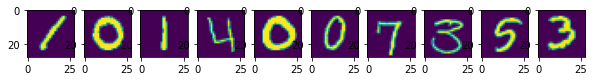

In [4]:
import pylab

fig = pylab.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(1,10, i + 1)
    pylab.imshow(data[i].reshape(28, 28))
pylab.show()

Смотрю на то, какие данные получились:

In [5]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

train_x, test_x, train_labels, test_labels = sklearn.model_selection.train_test_split(data, labels, test_size = 0.2, train_size = 0.8, shuffle = False)

# Подготовка к обучению

In [7]:
import torch
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)

Создам DataLoader-ы для обучения

In [8]:
trainDataset = torch.utils.data.TensorDataset(torch.tensor(train_x, dtype = torch.float32),torch.tensor(train_labels, dtype = torch.int32, device=device))
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size = 128)

validationDataset = torch.utils.data.TensorDataset(torch.tensor(test_x, dtype = torch.float32),torch.tensor(test_labels, dtype = torch.int32, device=device))
validationDataloader = torch.utils.data.DataLoader(validationDataset, batch_size = len(list(validationDataset)))

Класс для обучения нейросети и построения графиков

In [9]:
class Trainer:
    def __init__(self):        
        self.trainLossHistory = []
        self.validationLossHistory = []
        self.trainAccHistory = []
        self.validationAccHistory = []
        
    def calcAcc(self, z, y):
        faults = 0
        for i in range(len(z)):
            if z[i] != y[i]:
                faults += 1
        return (len(z) - faults) / len(z)
        
    def train(self, net, trainDataloader, validationDataloader, optim = torch.optim.Adam,
              loss = torch.nn.functional.cross_entropy, epochs = 10, lr = 0.05):
      optim = optim(net.parameters(), lr=lr)
      for ep in range(epochs):
        for (x, y) in trainDataloader:
          yOneHot = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=10)
          yOneHot = yOneHot.to(torch.float32)
          x = x.to(device)
          z = net(x)
#           z = torch.nn.functional.softmax(z, dim=0)
        
          trainLoss = loss(z, yOneHot)
          trainAcc = self.calcAcc(torch.argmax(z, dim=1), y)
          optim.zero_grad()
          trainLoss.backward()
          optim.step()
            
        val_x, val_y = next(iter(validationDataloader))
        valYOneHot = torch.nn.functional.one_hot(val_y.to(torch.int64), num_classes=10)
        valYOneHot = valYOneHot.to(torch.float32)
        val_x = val_x.to(device)
        val_z = net(val_x)
        val_z = val_z.to(device)
#         val_z = torch.nn.functional.softmax(val_z, dim=0)
        valLoss = loss(val_z, valYOneHot)
        valAcc = self.calcAcc(torch.argmax(val_z, dim=1), val_y)
        
        print(f"Epoch {ep}: last batch loss = {trainLoss}, val acc = {valAcc}")
        
        self.trainLossHistory.append(trainLoss.cpu().detach().numpy())
        self.validationLossHistory.append(valLoss.cpu().detach().numpy())
        self.trainAccHistory.append(trainAcc)
        self.validationAccHistory.append(valAcc)
    
    def plotHistory(self):
        figure = plt.figure(figsize = (15, 5))
        axes = figure.add_subplot(121)
        plt.title("accuracy")
        plt.plot(self.trainAccHistory, label="train acc")
        plt.plot(self.validationAccHistory, label="test acc")
        plt.legend(loc="upper left")
        
        axes = figure.add_subplot(122)
        plt.title("loss")
        plt.plot(self.trainLossHistory, label="train loss")
        plt.plot(self.validationLossHistory, label="test loss")
        plt.legend(loc="upper left")
        plt.show()
        
    def draw_confusion_matrix(self, net, validationDataloader, n = 10):
        x, y = next(iter(validationDataloader))
        x = x.to(device)
        p = net(x)
        predictions = np.argmax(p.cpu().detach().numpy(), axis = 1)
        confusion_matrix = []
        for i in range(n):
            confusion_matrix.append([0]*n)
            
        for i in range(len(predictions)):
            confusion_matrix[predictions[i]][y[i]] += 1
            
        figure = plt.figure(figsize = (10, 10))
        caxes = plt.matshow(confusion_matrix)
        plt.show()

# Однослойный персептрон

In [10]:
net = torch.nn.Linear(784, 10)
net = net.to(device)

Epoch 0: last batch loss = 12.08680534362793, val acc = 0.8683333333333333
Epoch 1: last batch loss = 9.04080867767334, val acc = 0.8580952380952381
Epoch 2: last batch loss = 9.661994934082031, val acc = 0.8828571428571429
Epoch 3: last batch loss = 11.285825729370117, val acc = 0.8620238095238095
Epoch 4: last batch loss = 11.95536994934082, val acc = 0.8470238095238095
Epoch 5: last batch loss = 10.064530372619629, val acc = 0.8709523809523809
Epoch 6: last batch loss = 7.103268623352051, val acc = 0.8486904761904762
Epoch 7: last batch loss = 8.472618103027344, val acc = 0.8867857142857143
Epoch 8: last batch loss = 9.237018585205078, val acc = 0.8927380952380952
Epoch 9: last batch loss = 9.315479278564453, val acc = 0.7808333333333334
Epoch 10: last batch loss = 8.118650436401367, val acc = 0.8647619047619047
Epoch 11: last batch loss = 7.192300796508789, val acc = 0.8580952380952381
Epoch 12: last batch loss = 6.145315647125244, val acc = 0.8883333333333333
Epoch 13: last batch 

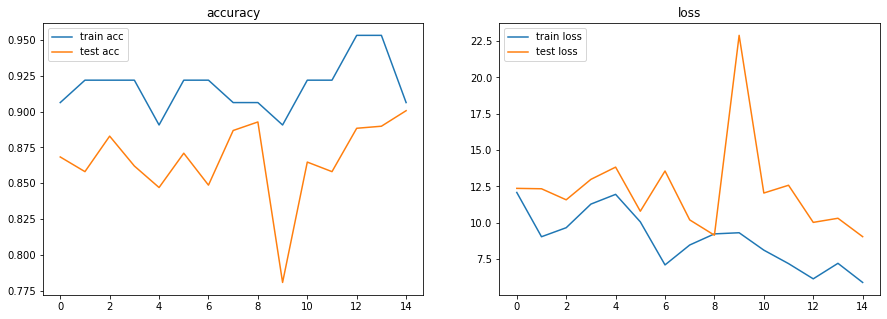

<Figure size 720x720 with 0 Axes>

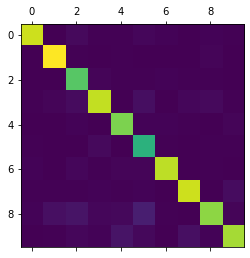

In [11]:
trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

# Многослойный персептрон

Epoch 0: last batch loss = 0.3164236843585968, val acc = 0.8753571428571428
Epoch 1: last batch loss = 0.18615227937698364, val acc = 0.9046428571428572
Epoch 2: last batch loss = 0.1328091025352478, val acc = 0.9169047619047619
Epoch 3: last batch loss = 0.10010677576065063, val acc = 0.9253571428571429
Epoch 4: last batch loss = 0.07794535160064697, val acc = 0.9315476190476191
Epoch 5: last batch loss = 0.06435520946979523, val acc = 0.9339285714285714
Epoch 6: last batch loss = 0.05465838685631752, val acc = 0.935952380952381
Epoch 7: last batch loss = 0.04796082526445389, val acc = 0.9392857142857143
Epoch 8: last batch loss = 0.04173317551612854, val acc = 0.9416666666666667
Epoch 9: last batch loss = 0.037065595388412476, val acc = 0.9433333333333334
Epoch 10: last batch loss = 0.033376261591911316, val acc = 0.9454761904761905
Epoch 11: last batch loss = 0.030070368200540543, val acc = 0.9461904761904761
Epoch 12: last batch loss = 0.0277313943952322, val acc = 0.94785714285714

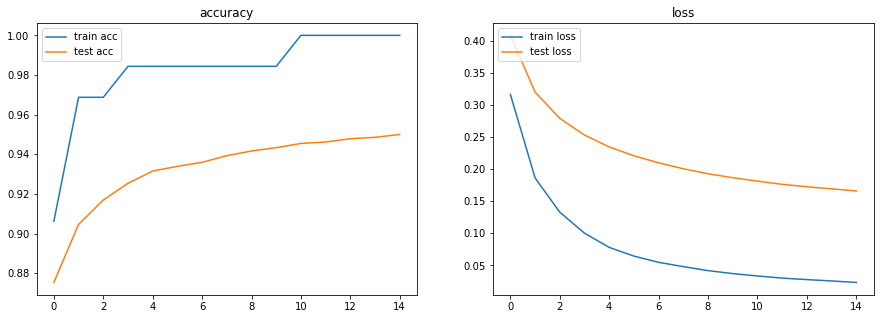

<Figure size 720x720 with 0 Axes>

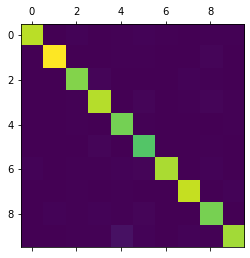

In [12]:
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

# Сравнение с различными гиперпараметрами

Буду отталкиваться от многослойной модели выше.

## Другие передаточные функции

Попробую гиперболический тангенс и сигмойду.

Tanh:
Epoch 0: last batch loss = 2.091517448425293, val acc = 0.48214285714285715
Epoch 1: last batch loss = 1.911543369293213, val acc = 0.6172619047619048
Epoch 2: last batch loss = 1.740748643875122, val acc = 0.6732142857142858
Epoch 3: last batch loss = 1.569098949432373, val acc = 0.6970238095238095
Epoch 4: last batch loss = 1.4266417026519775, val acc = 0.7178571428571429
Epoch 5: last batch loss = 1.278367280960083, val acc = 0.7439285714285714
Epoch 6: last batch loss = 1.1651209592819214, val acc = 0.7632142857142857
Epoch 7: last batch loss = 1.0549319982528687, val acc = 0.7803571428571429
Epoch 8: last batch loss = 0.9630867838859558, val acc = 0.799404761904762
Epoch 9: last batch loss = 0.8907738327980042, val acc = 0.8160714285714286
Epoch 10: last batch loss = 0.8219255208969116, val acc = 0.8304761904761905
Epoch 11: last batch loss = 0.7626231908798218, val acc = 0.8433333333333334
Epoch 12: last batch loss = 0.708473801612854, val acc = 0.8522619047619048
Epoch 13:

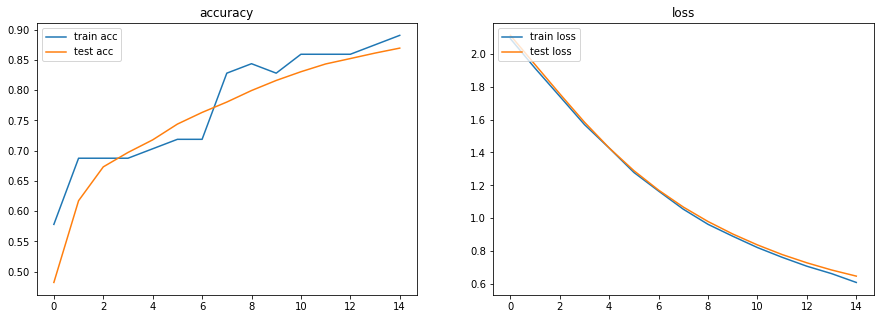

---------------------------------------------
Sigmoid:
Epoch 0: last batch loss = 2.316190481185913, val acc = 0.08892857142857143
Epoch 1: last batch loss = 2.2972569465637207, val acc = 0.1130952380952381
Epoch 2: last batch loss = 2.2910232543945312, val acc = 0.1130952380952381
Epoch 3: last batch loss = 2.2884724140167236, val acc = 0.1130952380952381
Epoch 4: last batch loss = 2.287175178527832, val acc = 0.1130952380952381
Epoch 5: last batch loss = 2.2863845825195312, val acc = 0.1130952380952381
Epoch 6: last batch loss = 2.2858657836914062, val acc = 0.1130952380952381
Epoch 7: last batch loss = 2.2854957580566406, val acc = 0.1130952380952381
Epoch 8: last batch loss = 2.285172939300537, val acc = 0.1130952380952381
Epoch 9: last batch loss = 2.2848567962646484, val acc = 0.1130952380952381
Epoch 10: last batch loss = 2.284518241882324, val acc = 0.1130952380952381
Epoch 11: last batch loss = 2.284179449081421, val acc = 0.1130952380952381
Epoch 12: last batch loss = 2.28386

<Figure size 720x720 with 0 Axes>

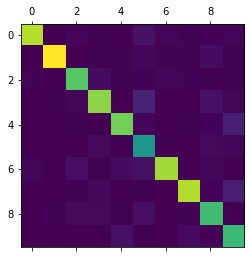

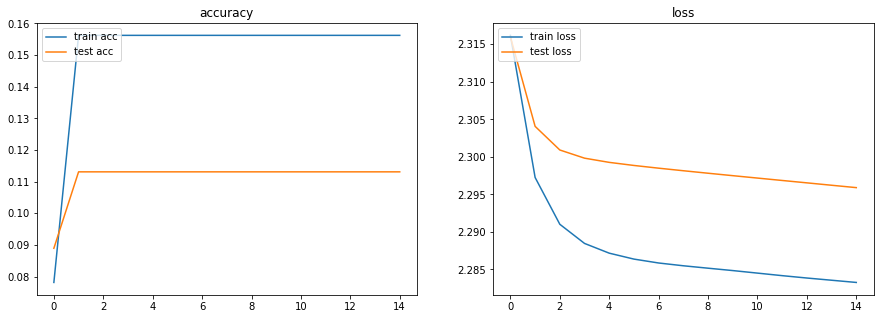

<Figure size 720x720 with 0 Axes>

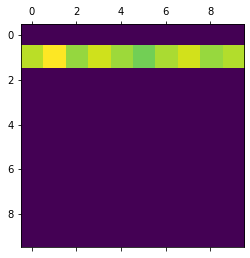

In [13]:
print("Tanh:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 100),
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 100),
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

print("---------------------------------------------")
print("Sigmoid:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.Sigmoid(),
                          torch.nn.Linear(100, 100),
                          torch.nn.Sigmoid(),
                          torch.nn.Linear(100, 100),
                          torch.nn.Sigmoid(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

Другие передаточные функции не позволили учулшить качество молели. По графикам видно, то результат учушается, но недостаточно быстро.

## Другое число нейронов

Кажется, что чем больше неронов, тем лучше. Но чем больше количество, тем дольше модель будет обучаться. Попробуем 10, 25, 50, 100, 200, 500 нейронов в промежуточном слое.

---------------------------------------------
10 neurons:
Epoch 0: last batch loss = 1.4145786762237549, val acc = 0.49702380952380953
Epoch 1: last batch loss = 1.1060762405395508, val acc = 0.660952380952381
Epoch 2: last batch loss = 0.8405992984771729, val acc = 0.7467857142857143
Epoch 3: last batch loss = 0.695991039276123, val acc = 0.7897619047619048
Epoch 4: last batch loss = 0.6052912473678589, val acc = 0.8185714285714286
Epoch 5: last batch loss = 0.5506068468093872, val acc = 0.8398809523809524
Epoch 6: last batch loss = 0.5230114459991455, val acc = 0.856547619047619
Epoch 7: last batch loss = 0.5033431053161621, val acc = 0.866547619047619
Epoch 8: last batch loss = 0.46797120571136475, val acc = 0.8716666666666667
Epoch 9: last batch loss = 0.43472424149513245, val acc = 0.8741666666666666
Epoch 10: last batch loss = 0.4137405753135681, val acc = 0.8788095238095238
Epoch 11: last batch loss = 0.3873329758644104, val acc = 0.8792857142857143
Epoch 12: last batch loss = 0

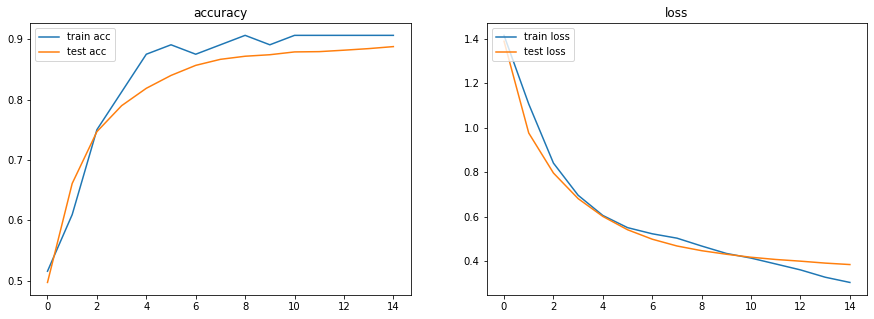

---------------------------------------------
25 neurons:
Epoch 0: last batch loss = 0.5273352861404419, val acc = 0.8244047619047619
Epoch 1: last batch loss = 0.3153914213180542, val acc = 0.8773809523809524
Epoch 2: last batch loss = 0.2447919100522995, val acc = 0.8955952380952381
Epoch 3: last batch loss = 0.2099071443080902, val acc = 0.9046428571428572
Epoch 4: last batch loss = 0.1847260743379593, val acc = 0.9098809523809523
Epoch 5: last batch loss = 0.17068389058113098, val acc = 0.9126190476190477
Epoch 6: last batch loss = 0.15510810911655426, val acc = 0.915952380952381
Epoch 7: last batch loss = 0.14632956683635712, val acc = 0.919404761904762
Epoch 8: last batch loss = 0.14050976932048798, val acc = 0.9220238095238096
Epoch 9: last batch loss = 0.13693498075008392, val acc = 0.9241666666666667
Epoch 10: last batch loss = 0.1356692910194397, val acc = 0.9269047619047619
Epoch 11: last batch loss = 0.13430656492710114, val acc = 0.9288095238095239
Epoch 12: last batch los

<Figure size 720x720 with 0 Axes>

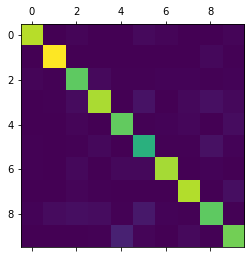

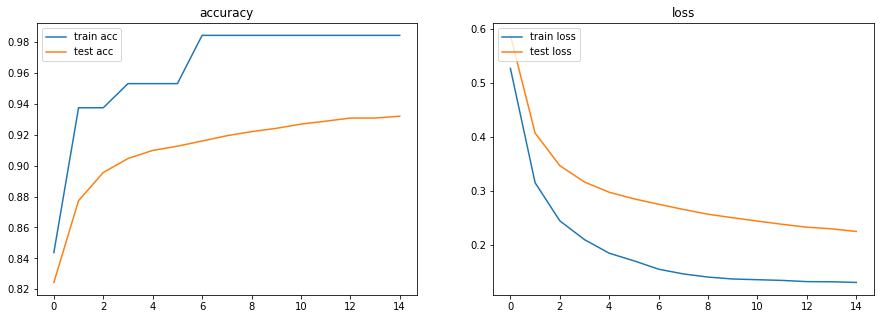

---------------------------------------------
50 neurons:
Epoch 0: last batch loss = 0.5008383989334106, val acc = 0.8436904761904762
Epoch 1: last batch loss = 0.3114794194698334, val acc = 0.8917857142857143
Epoch 2: last batch loss = 0.22363437712192535, val acc = 0.9082142857142858
Epoch 3: last batch loss = 0.18093912303447723, val acc = 0.9166666666666666
Epoch 4: last batch loss = 0.1557326316833496, val acc = 0.9234523809523809
Epoch 5: last batch loss = 0.13813169300556183, val acc = 0.9282142857142858
Epoch 6: last batch loss = 0.12575876712799072, val acc = 0.9323809523809524
Epoch 7: last batch loss = 0.11549099534749985, val acc = 0.9353571428571429
Epoch 8: last batch loss = 0.10796504467725754, val acc = 0.9373809523809524
Epoch 9: last batch loss = 0.10155389457941055, val acc = 0.939047619047619
Epoch 10: last batch loss = 0.09576612710952759, val acc = 0.9404761904761905
Epoch 11: last batch loss = 0.0907924696803093, val acc = 0.9432142857142857
Epoch 12: last batch 

<Figure size 720x720 with 0 Axes>

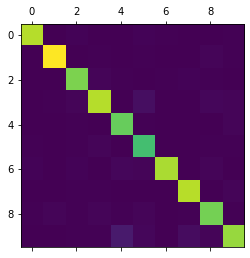

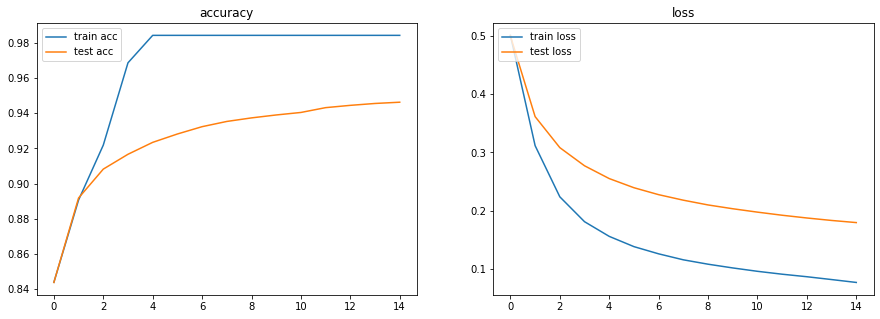

---------------------------------------------
200 neurons:
Epoch 0: last batch loss = 0.2904931902885437, val acc = 0.8879761904761905
Epoch 1: last batch loss = 0.19766449928283691, val acc = 0.9129761904761905
Epoch 2: last batch loss = 0.15544670820236206, val acc = 0.9245238095238095
Epoch 3: last batch loss = 0.13249878585338593, val acc = 0.9313095238095238
Epoch 4: last batch loss = 0.11389517784118652, val acc = 0.9360714285714286
Epoch 5: last batch loss = 0.09882352501153946, val acc = 0.9394047619047619
Epoch 6: last batch loss = 0.08687318116426468, val acc = 0.9428571428571428
Epoch 7: last batch loss = 0.07660065591335297, val acc = 0.945952380952381
Epoch 8: last batch loss = 0.06709092855453491, val acc = 0.9477380952380953
Epoch 9: last batch loss = 0.05901186168193817, val acc = 0.9497619047619048
Epoch 10: last batch loss = 0.052404627203941345, val acc = 0.9510714285714286
Epoch 11: last batch loss = 0.04599558189511299, val acc = 0.9519047619047619
Epoch 12: last b

<Figure size 720x720 with 0 Axes>

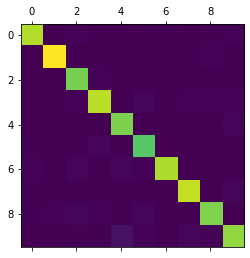

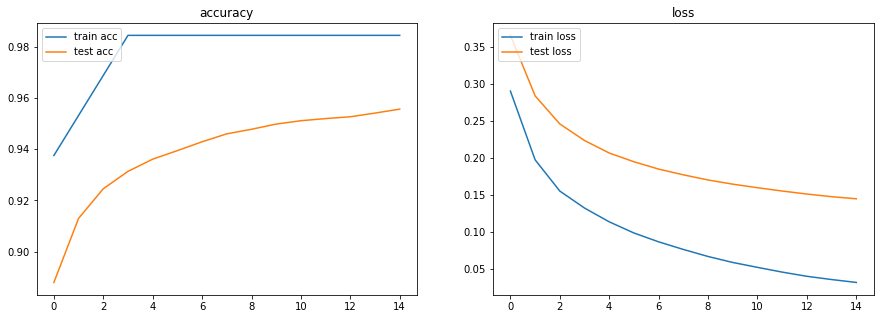

---------------------------------------------
500 neurons:
Epoch 0: last batch loss = 0.2586466670036316, val acc = 0.9052380952380953
Epoch 1: last batch loss = 0.16021715104579926, val acc = 0.9266666666666666
Epoch 2: last batch loss = 0.11059492826461792, val acc = 0.9379761904761905
Epoch 3: last batch loss = 0.0853460505604744, val acc = 0.9425
Epoch 4: last batch loss = 0.06695947051048279, val acc = 0.9458333333333333
Epoch 5: last batch loss = 0.053270287811756134, val acc = 0.9494047619047619
Epoch 6: last batch loss = 0.0429573729634285, val acc = 0.9522619047619048
Epoch 7: last batch loss = 0.03549664467573166, val acc = 0.9536904761904762
Epoch 8: last batch loss = 0.02963368408381939, val acc = 0.9553571428571429
Epoch 9: last batch loss = 0.02557552605867386, val acc = 0.9563095238095238
Epoch 10: last batch loss = 0.022318124771118164, val acc = 0.9564285714285714
Epoch 11: last batch loss = 0.019795812666416168, val acc = 0.9572619047619048
Epoch 12: last batch loss =

<Figure size 720x720 with 0 Axes>

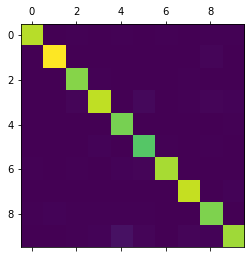

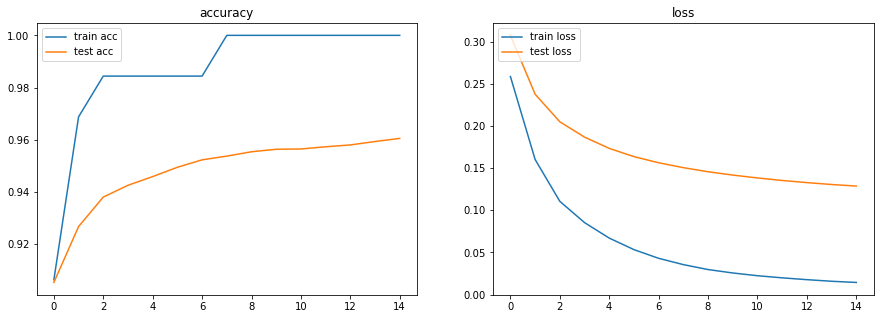

<Figure size 720x720 with 0 Axes>

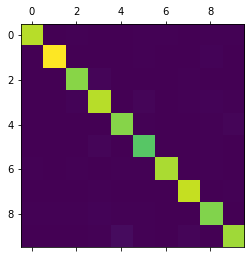

In [14]:
neuron_nums = [10, 25, 50, 200, 500]

for neuron_num in neuron_nums:
    print("---------------------------------------------")
    print(neuron_num, "neurons:")
    net = torch.nn.Sequential(torch.nn.Linear(784, neuron_num), 
                              torch.nn.ReLU(),
                              torch.nn.Linear(neuron_num, neuron_num),
                              torch.nn.ReLU(),
                              torch.nn.Linear(neuron_num, neuron_num),
                              torch.nn.ReLU(),
                              torch.nn.Linear(neuron_num, 10))
    net = net.to(device)

    trainer = Trainer()
    trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
                  torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

    trainer.plotHistory()
    trainer.draw_confusion_matrix(net, validationDataloader)

Чем больше число нейронов, тем лучше получался результат. Однако, скокрость обучения резко падает с их ростом. Остановлюсь на 200-х.

## Другие функции потерь

Попробую MSELoss и L1Loss.

MSELoss:
Epoch 0: last batch loss = 0.09872332960367203, val acc = 0.17976190476190476
Epoch 1: last batch loss = 0.09078341722488403, val acc = 0.27964285714285714
Epoch 2: last batch loss = 0.08530408143997192, val acc = 0.3611904761904762
Epoch 3: last batch loss = 0.08048572391271591, val acc = 0.4170238095238095
Epoch 4: last batch loss = 0.07731907814741135, val acc = 0.4651190476190476
Epoch 5: last batch loss = 0.07382446527481079, val acc = 0.501547619047619
Epoch 6: last batch loss = 0.07101137191057205, val acc = 0.5296428571428572
Epoch 7: last batch loss = 0.06975071132183075, val acc = 0.5565476190476191
Epoch 8: last batch loss = 0.06853432208299637, val acc = 0.5760714285714286
Epoch 9: last batch loss = 0.06722304224967957, val acc = 0.5942857142857143
Epoch 10: last batch loss = 0.06607478857040405, val acc = 0.6097619047619047
Epoch 11: last batch loss = 0.06475599855184555, val acc = 0.6267857142857143
Epoch 12: last batch loss = 0.06320230662822723, val acc = 0.642

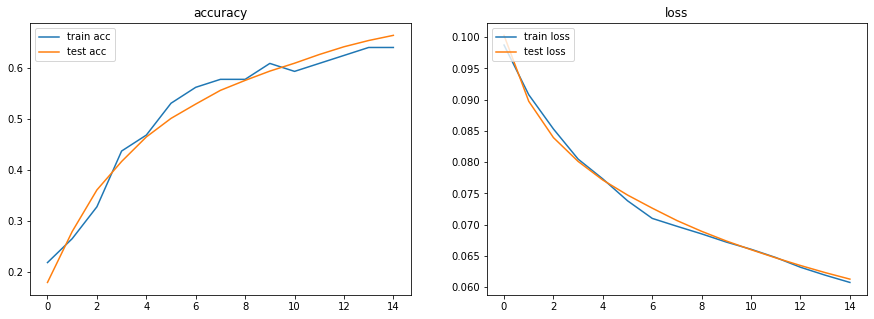

---------------------------------------------
L1Loss:
Epoch 0: last batch loss = 0.17628096044063568, val acc = 0.1138095238095238
Epoch 1: last batch loss = 0.1652492731809616, val acc = 0.15904761904761905
Epoch 2: last batch loss = 0.15584510564804077, val acc = 0.20226190476190475
Epoch 3: last batch loss = 0.14752958714962006, val acc = 0.24214285714285713
Epoch 4: last batch loss = 0.14203166961669922, val acc = 0.2786904761904762
Epoch 5: last batch loss = 0.13814237713813782, val acc = 0.3026190476190476
Epoch 6: last batch loss = 0.13422976434230804, val acc = 0.32392857142857145
Epoch 7: last batch loss = 0.1303033083677292, val acc = 0.34154761904761904
Epoch 8: last batch loss = 0.1281258761882782, val acc = 0.3473809523809524
Epoch 9: last batch loss = 0.12611709535121918, val acc = 0.36047619047619045
Epoch 10: last batch loss = 0.12404190748929977, val acc = 0.36773809523809525
Epoch 11: last batch loss = 0.12230167537927628, val acc = 0.3761904761904762
Epoch 12: last b

<Figure size 720x720 with 0 Axes>

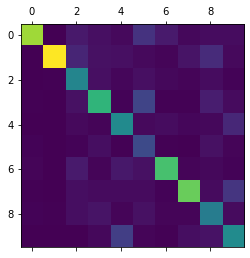

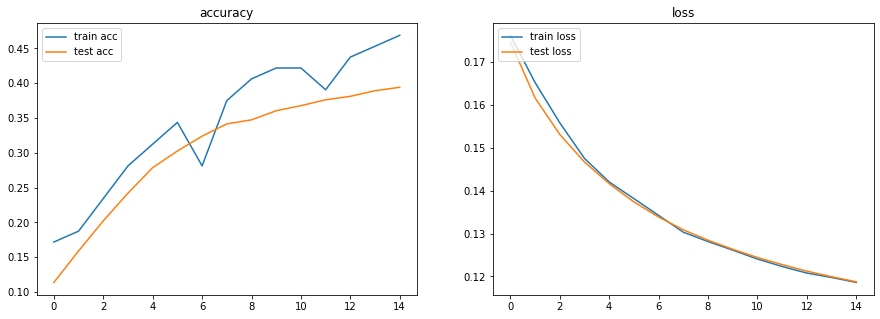

<Figure size 720x720 with 0 Axes>

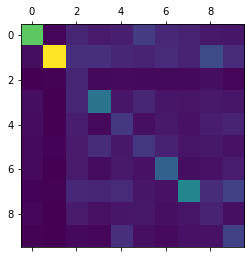

In [17]:
print("MSELoss:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 100),
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 100),
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
              torch.nn.functional.mse_loss, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

print("---------------------------------------------")
print("L1Loss:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 100),
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 100),
                          torch.nn.Tanh(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
              torch.nn.functional.l1_loss, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

Другие функции потрерь оказались неудачными, оставлю изначальную.

## Другое количество слоев

Кажется, что увеличчение количества слоев может улучшить результат. Но, как с увеличением числа нейронов, время обучения возрастет. Попробую количество слоев 2, 4, 5.

two layers:
Epoch 0: last batch loss = 0.35395461320877075, val acc = 0.8798809523809524
Epoch 1: last batch loss = 0.25009509921073914, val acc = 0.9105952380952381
Epoch 2: last batch loss = 0.20463190972805023, val acc = 0.9228571428571428
Epoch 3: last batch loss = 0.1744159311056137, val acc = 0.93
Epoch 4: last batch loss = 0.1539866328239441, val acc = 0.9346428571428571
Epoch 5: last batch loss = 0.14059776067733765, val acc = 0.9388095238095238
Epoch 6: last batch loss = 0.12101762741804123, val acc = 0.9421428571428572
Epoch 7: last batch loss = 0.10530474036931992, val acc = 0.9439285714285715
Epoch 8: last batch loss = 0.09222859144210815, val acc = 0.945952380952381
Epoch 9: last batch loss = 0.08280777931213379, val acc = 0.9482142857142857
Epoch 10: last batch loss = 0.07263561338186264, val acc = 0.9492857142857143
Epoch 11: last batch loss = 0.06545732915401459, val acc = 0.9508333333333333
Epoch 12: last batch loss = 0.056942183524370193, val acc = 0.9516666666666667


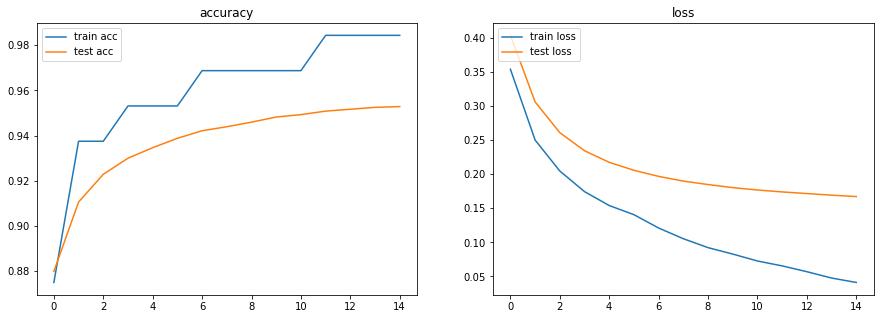

---------------------------------------------
four layers:
Epoch 0: last batch loss = 0.459911048412323, val acc = 0.8509523809523809
Epoch 1: last batch loss = 0.29689764976501465, val acc = 0.8914285714285715
Epoch 2: last batch loss = 0.22374354302883148, val acc = 0.9091666666666667
Epoch 3: last batch loss = 0.18299971520900726, val acc = 0.9178571428571428
Epoch 4: last batch loss = 0.15687501430511475, val acc = 0.9238095238095239
Epoch 5: last batch loss = 0.1366916447877884, val acc = 0.9280952380952381
Epoch 6: last batch loss = 0.11927443742752075, val acc = 0.9315476190476191
Epoch 7: last batch loss = 0.10739236325025558, val acc = 0.9354761904761905
Epoch 8: last batch loss = 0.09817212074995041, val acc = 0.9376190476190476
Epoch 9: last batch loss = 0.08866079151630402, val acc = 0.9395238095238095
Epoch 10: last batch loss = 0.08178656548261642, val acc = 0.9417857142857143
Epoch 11: last batch loss = 0.0751609057188034, val acc = 0.9438095238095238
Epoch 12: last batc

<Figure size 720x720 with 0 Axes>

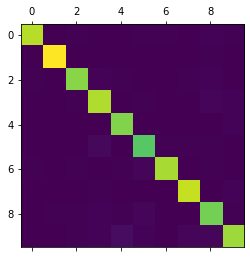

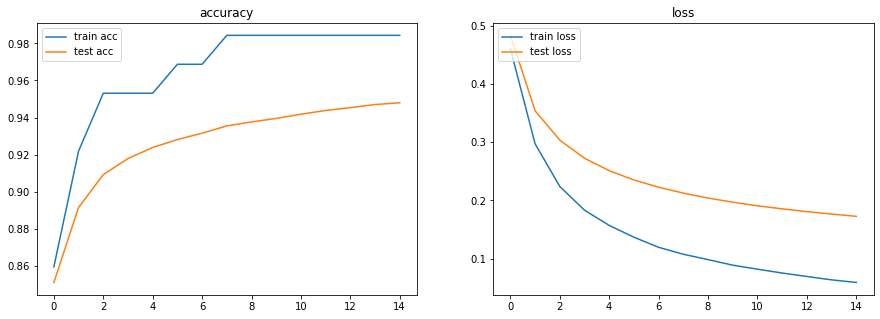

---------------------------------------------
five layers:
Epoch 0: last batch loss = 0.14189516007900238, val acc = 0.9427380952380953
Epoch 1: last batch loss = 0.07488597929477692, val acc = 0.9635714285714285
Epoch 2: last batch loss = 0.04758508503437042, val acc = 0.9604761904761905
Epoch 3: last batch loss = 0.01446635089814663, val acc = 0.9610714285714286
Epoch 4: last batch loss = 0.017116745933890343, val acc = 0.9622619047619048
Epoch 5: last batch loss = 0.01497578714042902, val acc = 0.9660714285714286
Epoch 6: last batch loss = 0.011922691948711872, val acc = 0.9673809523809523
Epoch 7: last batch loss = 0.003168686991557479, val acc = 0.9692857142857143
Epoch 8: last batch loss = 0.0025836401619017124, val acc = 0.9692857142857143
Epoch 9: last batch loss = 0.005144335795193911, val acc = 0.9673809523809523
Epoch 10: last batch loss = 0.024722861126065254, val acc = 0.9707142857142858
Epoch 11: last batch loss = 0.0013929635751992464, val acc = 0.9661904761904762
Epoch 

<Figure size 720x720 with 0 Axes>

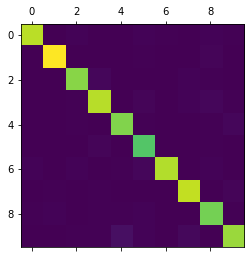

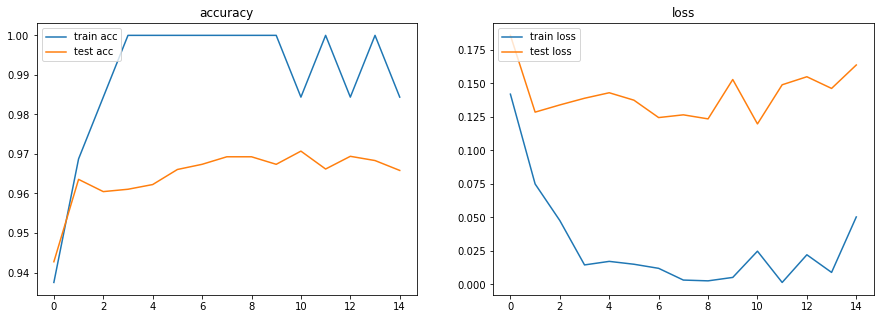

<Figure size 720x720 with 0 Axes>

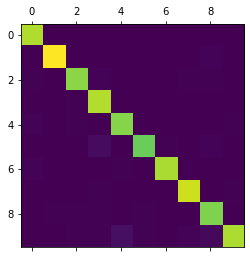

In [18]:
print("two layers:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

print("---------------------------------------------")
print("four layers:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.SGD,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

print("---------------------------------------------")
print("five layers:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
optim = torch.optim.Adam(net.parameters(), lr=0.05)
trainer.train(net, trainDataloader, validationDataloader, torch.optim.Adam,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

С ростом солев качество модели увелисичается, но очень слабо.

## Другие модели обучения

Попробую Adam, RMSprop и Adamax.

Adam:
Epoch 0: last batch loss = 0.1855839490890503, val acc = 0.9445238095238095
Epoch 1: last batch loss = 0.08525098860263824, val acc = 0.9589285714285715
Epoch 2: last batch loss = 0.03005489893257618, val acc = 0.9608333333333333
Epoch 3: last batch loss = 0.00923111941665411, val acc = 0.9622619047619048
Epoch 4: last batch loss = 0.031297117471694946, val acc = 0.9603571428571429
Epoch 5: last batch loss = 0.0020170677453279495, val acc = 0.9641666666666666
Epoch 6: last batch loss = 0.005107631906867027, val acc = 0.9607142857142857
Epoch 7: last batch loss = 0.02783246338367462, val acc = 0.9582142857142857
Epoch 8: last batch loss = 0.0010278539266437292, val acc = 0.9508333333333333
Epoch 9: last batch loss = 0.02857668325304985, val acc = 0.9635714285714285
Epoch 10: last batch loss = 0.03042135387659073, val acc = 0.9621428571428572
Epoch 11: last batch loss = 0.0006587305688299239, val acc = 0.9665476190476191
Epoch 12: last batch loss = 0.03464854881167412, val acc = 0.

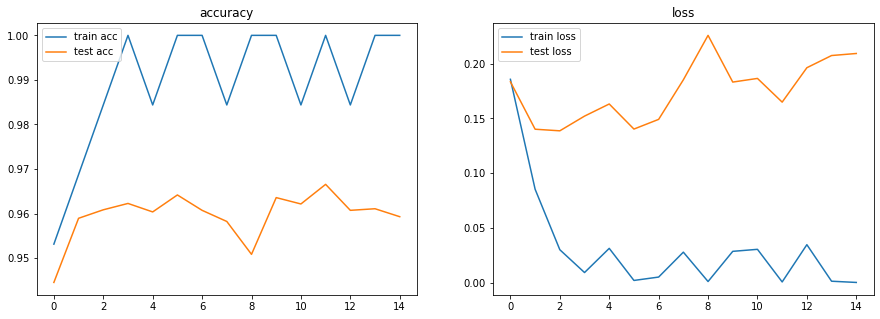

---------------------------------------------
RMSprop:
Epoch 0: last batch loss = 0.1423807442188263, val acc = 0.9469047619047619
Epoch 1: last batch loss = 0.04912882298231125, val acc = 0.9545238095238096
Epoch 2: last batch loss = 0.011822771281003952, val acc = 0.9579761904761904
Epoch 3: last batch loss = 0.01420553494244814, val acc = 0.9589285714285715
Epoch 4: last batch loss = 0.00473282253369689, val acc = 0.9619047619047619
Epoch 5: last batch loss = 0.02803008444607258, val acc = 0.9625
Epoch 6: last batch loss = 0.017057809978723526, val acc = 0.9621428571428572
Epoch 7: last batch loss = 0.05056170001626015, val acc = 0.9619047619047619
Epoch 8: last batch loss = 0.020133979618549347, val acc = 0.9635714285714285
Epoch 9: last batch loss = 0.0012054508551955223, val acc = 0.9635714285714285
Epoch 10: last batch loss = 0.000576995313167572, val acc = 0.9558333333333333
Epoch 11: last batch loss = 0.0776388943195343, val acc = 0.9608333333333333
Epoch 12: last batch loss =

<Figure size 720x720 with 0 Axes>

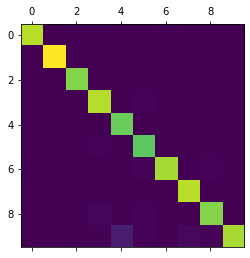

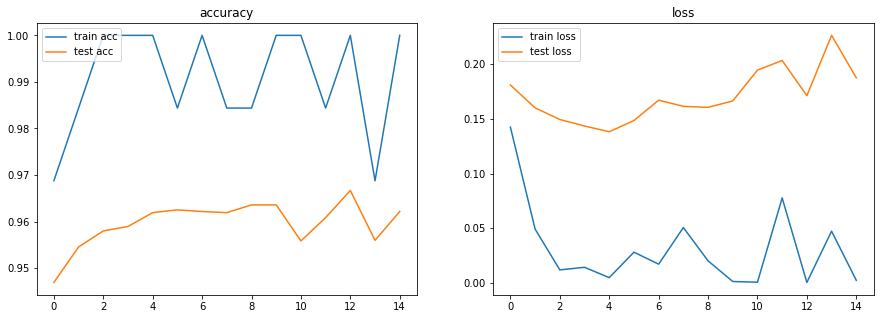

---------------------------------------------
Adamax:
Epoch 0: last batch loss = 0.1799209713935852, val acc = 0.9427380952380953
Epoch 1: last batch loss = 0.022938799113035202, val acc = 0.9541666666666667
Epoch 2: last batch loss = 0.029637068510055542, val acc = 0.9576190476190476
Epoch 3: last batch loss = 0.05166338384151459, val acc = 0.9528571428571428
Epoch 4: last batch loss = 0.02041422389447689, val acc = 0.9639285714285715
Epoch 5: last batch loss = 0.03177709877490997, val acc = 0.9621428571428572
Epoch 6: last batch loss = 0.0605384036898613, val acc = 0.9627380952380953
Epoch 7: last batch loss = 0.0018379396060481668, val acc = 0.9632142857142857
Epoch 8: last batch loss = 0.0019693314097821712, val acc = 0.9639285714285715
Epoch 9: last batch loss = 0.0038021691143512726, val acc = 0.9658333333333333
Epoch 10: last batch loss = 0.0006361064151860774, val acc = 0.9617857142857142
Epoch 11: last batch loss = 0.005452949088066816, val acc = 0.9605952380952381
Epoch 12: l

<Figure size 720x720 with 0 Axes>

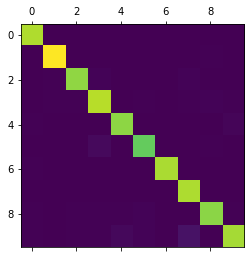

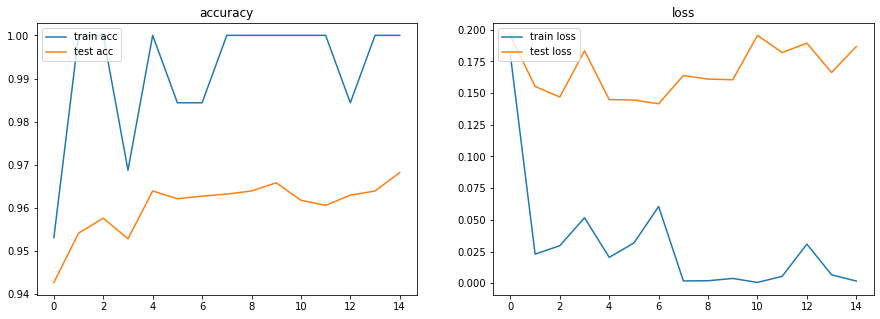

<Figure size 720x720 with 0 Axes>

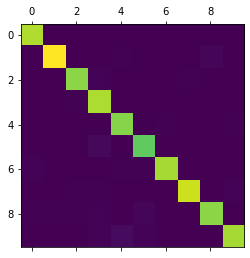

In [19]:
print("Adam:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
optim = torch.optim.Adam
trainer.train(net, trainDataloader, validationDataloader, torch.optim.Adam,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

print("---------------------------------------------")
print("RMSprop:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
optim = torch.optim.RMSprop
trainer.train(net, trainDataloader, validationDataloader, torch.optim.Adam,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

print("---------------------------------------------")
print("Adamax:")
net = torch.nn.Sequential(torch.nn.Linear(784, 100), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 100),
                          torch.nn.ReLU(),
                          torch.nn.Linear(100, 10))
net = net.to(device)

trainer = Trainer()
optim = torch.optim.Adamax
trainer.train(net, trainDataloader, validationDataloader, torch.optim.Adam,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

Три выбраных алгорима обучения оказались сильно лучше градиентного спуска. Качества моделей обученных ими примерно одинаковы. Остановлюсь на Adamax

## Улучшение результата

Попробую использовать наилучшее гиперепараметры и учлушить качество предсказаний. Также увеличу число эпох и learning rate.

Epoch 0: last batch loss = 0.08897550404071808, val acc = 0.9513095238095238
Epoch 1: last batch loss = 0.06513038277626038, val acc = 0.9616666666666667
Epoch 2: last batch loss = 0.012350644916296005, val acc = 0.9630952380952381
Epoch 3: last batch loss = 0.003318623173981905, val acc = 0.9620238095238095
Epoch 4: last batch loss = 0.01276406366378069, val acc = 0.9707142857142858
Epoch 5: last batch loss = 0.006601982284337282, val acc = 0.9683333333333334
Epoch 6: last batch loss = 0.0028747511096298695, val acc = 0.9655952380952381
Epoch 7: last batch loss = 0.006075550802052021, val acc = 0.960952380952381
Epoch 8: last batch loss = 0.001774434233084321, val acc = 0.9698809523809524
Epoch 9: last batch loss = 0.06380748748779297, val acc = 0.9746428571428571
Epoch 10: last batch loss = 0.002809178549796343, val acc = 0.9708333333333333
Epoch 11: last batch loss = 0.005605454556643963, val acc = 0.9677380952380953
Epoch 12: last batch loss = 0.0015656061004847288, val acc = 0.975

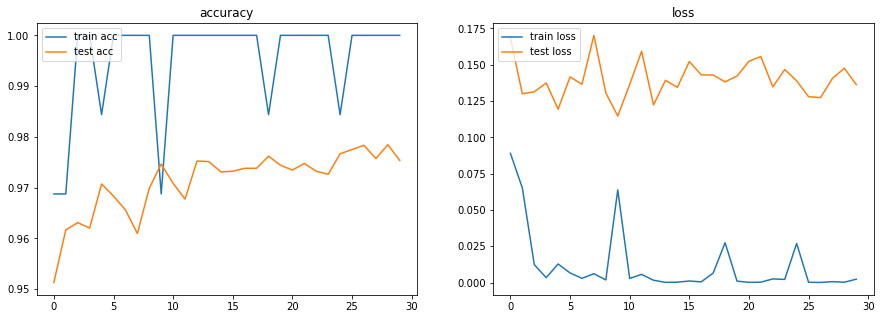

<Figure size 720x720 with 0 Axes>

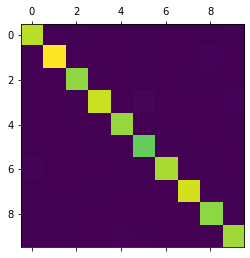

In [21]:
net = torch.nn.Sequential(torch.nn.Linear(784, 200), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 10))
net = net.to(device)

trainer = Trainer()
optim = torch.optim.Adamax
trainer.train(net, trainDataloader, validationDataloader, torch.optim.Adam,
              torch.nn.functional.cross_entropy, epochs = 30, lr = 0.0005)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

Результат удалось улучшить до 97%

# FashionMNIST

In [41]:
!curl -o test-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
!curl -o test-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz
!curl -o train-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
!curl -o train-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz

import gzip
with gzip.open("test-labels.gz", "rb") as gz:
    test_y = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("test-images.gz", "rb") as gz:
    test_X = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(test_y), 784)
    
with gzip.open("train-labels.gz", "rb") as gz:
    train_y = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("train-images.gz", "rb") as gz:
    train_X = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(train_y), 784)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 31 4318k   31 1343k    0     0  1624k      0  0:00:02 --:--:--  0:00:02 1624k
100 4318k  100 4318k    0     0  2546k      0  0:00:01  0:00:01 --:--:-- 2547k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  5148  100  5148    0     0  18374      0 --:--:-- --:--:-- --:--:-- 18385
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:

Взгляну на данные

In [42]:
train_X.shape

(60000, 784)

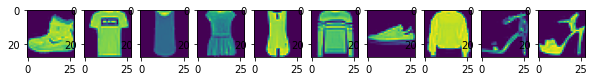

In [43]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(train_X[i].reshape(28,28))
pylab.show()

In [44]:
trainDataset = torch.utils.data.TensorDataset(torch.tensor(train_X, dtype = torch.float32),
                                              torch.tensor(train_y, dtype = torch.float32, 
                                              device=device))
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size = 128)

validationDataset = torch.utils.data.TensorDataset(torch.tensor(test_X, dtype = torch.float32),
                                                   torch.tensor(test_y, dtype = torch.int32, 
                                                   device=device))
validationDataloader = torch.utils.data.DataLoader(validationDataset, batch_size = len(list(validationDataset)))

Epoch 0: last batch loss = 0.4354783892631531, val acc = 0.837
Epoch 1: last batch loss = 0.3412204682826996, val acc = 0.8526
Epoch 2: last batch loss = 0.3239293098449707, val acc = 0.8658
Epoch 3: last batch loss = 0.31073781847953796, val acc = 0.864
Epoch 4: last batch loss = 0.3222963511943817, val acc = 0.8675
Epoch 5: last batch loss = 0.2219531387090683, val acc = 0.8695
Epoch 6: last batch loss = 0.2334778755903244, val acc = 0.868
Epoch 7: last batch loss = 0.20042340457439423, val acc = 0.8682
Epoch 8: last batch loss = 0.18564754724502563, val acc = 0.8737
Epoch 9: last batch loss = 0.22921350598335266, val acc = 0.8715
Epoch 10: last batch loss = 0.15447136759757996, val acc = 0.8758
Epoch 11: last batch loss = 0.17431682348251343, val acc = 0.8696
Epoch 12: last batch loss = 0.17071960866451263, val acc = 0.8713
Epoch 13: last batch loss = 0.14057105779647827, val acc = 0.8743
Epoch 14: last batch loss = 0.13177333772182465, val acc = 0.8786


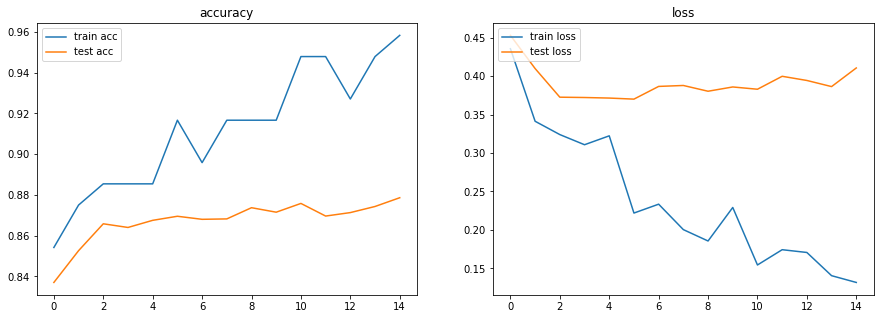

<Figure size 720x720 with 0 Axes>

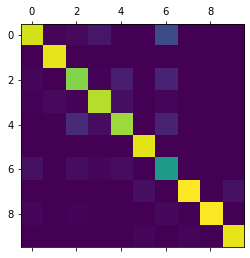

In [45]:
net = torch.nn.Sequential(torch.nn.Linear(784, 200), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.Adamax,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)

Результат сразу получился выше 85%.

# CIFAR-10

In [34]:
!curl -o cifar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
import gzip
!tar -xvf cifar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  162M    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  162M    0  400k    0     0   192k      0  0:14:27  0:00:02  0:14:25  192k
  0  162M    0  848k    0     0   280k      0  0:09:53  0:00:03  0:09:50  280k
  0  162M    0 1344k    0     0   328k      0  0:08:27  0:00:04  0:08:23  328k
  1  162M    1 1792k    0     0   355k      0  0:07:47  0:00:05  0:07:42  357k
  1  162M    1 2288k    0     0   374k      0  0:07:24  0:00:06  0:07:18  460k
  1  162M    1 2720k    0     0   385k      0  0:07:11  0:00:07  0:07:04  466k
  1  162M    1 3232k    0     0   397k      0  0:06:58  0:00:08  0:06:50  467k
  2  162M    2 3664k    0     0   404k      0  0:06

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [46]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [47]:
a = unpickle("./cifar-10-batches-py/data_batch_1")
train_x = a[b'data']
train_y = a[b'labels']

a = unpickle("./cifar-10-batches-py/data_batch_2")
train_x = np.concatenate((train_x , a[b'data']), axis = 0)
train_y = np.append(train_y, a[b'labels'])

a = unpickle("./cifar-10-batches-py/data_batch_3")
train_x = np.concatenate((train_x , a[b'data']), axis = 0)
train_y = np.append(train_y, a[b'labels'])

a = unpickle("./cifar-10-batches-py/data_batch_4")
train_x = np.concatenate((train_x , a[b'data']), axis = 0)
train_y = np.append(train_y, a[b'labels'])

a = unpickle("./cifar-10-batches-py/data_batch_5")
test_x = a[b'data']
test_y = a[b'labels']

In [48]:
for i in range(len(train_x)):
    train_x[i] = np.concatenate(train_x[i].reshape(3, 32, 32, 1), axis=2).reshape(-1,)

for i in range(len(test_x)):
    test_x[i] = np.concatenate(test_x[i].reshape(3, 32, 32, 1), axis=2).reshape(-1,)

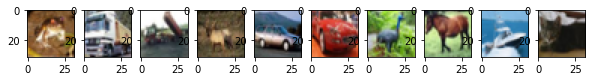

In [49]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    pylab.imshow(train_x[i].reshape(32, 32, 3))
pylab.show()

In [50]:
trainDataset = torch.utils.data.TensorDataset(torch.tensor(train_x, dtype = torch.float32),
                                              torch.tensor(train_y, dtype = torch.float32, 
                                              device=device))
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size = 128)

validationDataset = torch.utils.data.TensorDataset(torch.tensor(test_x, dtype = torch.float32),
                                                   torch.tensor(test_y, dtype = torch.int32, 
                                                   device=device))
validationDataloader = torch.utils.data.DataLoader(validationDataset, batch_size = len(list(validationDataset)))

Epoch 0: last batch loss = 1.964487075805664, val acc = 0.3121
Epoch 1: last batch loss = 1.818080186843872, val acc = 0.3617
Epoch 2: last batch loss = 1.639160394668579, val acc = 0.3795
Epoch 3: last batch loss = 1.5779907703399658, val acc = 0.3775
Epoch 4: last batch loss = 1.4964256286621094, val acc = 0.4074
Epoch 5: last batch loss = 1.5287363529205322, val acc = 0.4238
Epoch 6: last batch loss = 1.5347310304641724, val acc = 0.4275
Epoch 7: last batch loss = 1.384345293045044, val acc = 0.4302
Epoch 8: last batch loss = 1.3261748552322388, val acc = 0.4298
Epoch 9: last batch loss = 1.2195193767547607, val acc = 0.4284
Epoch 10: last batch loss = 1.257383108139038, val acc = 0.4526
Epoch 11: last batch loss = 1.1653485298156738, val acc = 0.4628
Epoch 12: last batch loss = 1.2291138172149658, val acc = 0.4555
Epoch 13: last batch loss = 1.2235568761825562, val acc = 0.4544
Epoch 14: last batch loss = 1.113980770111084, val acc = 0.4597


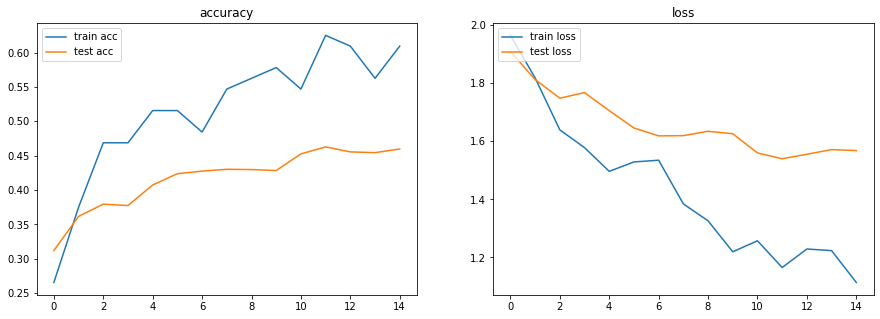

<Figure size 720x720 with 0 Axes>

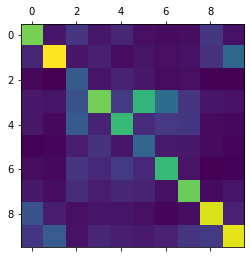

In [51]:
net = torch.nn.Sequential(torch.nn.Linear(3072, 200), 
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 200),
                          torch.nn.ReLU(),
                          torch.nn.Linear(200, 10))
net = net.to(device)

trainer = Trainer()
trainer.train(net, trainDataloader, validationDataloader, torch.optim.Adamax,
              torch.nn.functional.cross_entropy, epochs = 15, lr = 0.001)

trainer.plotHistory()
trainer.draw_confusion_matrix(net, validationDataloader)